In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import linear_model

from collections import defaultdict
from dataLoader import load_data_event
from statUtils import perform_regression

In [19]:
# load event data (make sure to download w/ downloadData.py)
event = 'week1/2020ncwak'
qualification_matches_wak, team_scores_wak, team_data_wak, team_component_opr_wak = load_data_event(event)

with open(f'data/{event}.json', 'r') as f:
    json_data = json.load(f)

team_keys = json_data['teams']

In [3]:
# load in all data from other events (for regression)
# make sure to generate using the other notebook

qualification_matches = pd.read_csv('data/saved_dataframes/week-1-qualification-matches.csv')
team_scores = pd.read_csv('data/saved_dataframes/week-1-team-scores.csv')
team_data = pd.read_csv('data/saved_dataframes/week-1-team-data.csv')
team_component_opr = pd.read_csv('data/saved_dataframes/week-1-team-component-opr.csv')

In [4]:
# get normalized component OPR to perform the regression
team_component_opr_normalized = team_component_opr.copy(deep=True)
team_component_opr_normalized['cells_bottom_auto'] *= 2
team_component_opr_normalized['cells_bottom_teleop'] *= 1
team_component_opr_normalized['cells_inner_auto'] *= 6
team_component_opr_normalized['cells_inner_teleop'] *= 3
team_component_opr_normalized['cells_outer_auto'] *= 4
team_component_opr_normalized['cells_outer_teleop'] *= 2

Text(0, 0.5, 'Points scored (excluding penalties)')

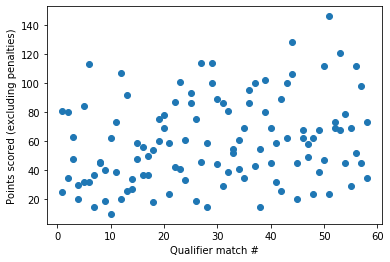

In [20]:
# graph score over time
plt.scatter(
    pd.concat([qualification_matches_wak['match_number'], qualification_matches_wak['match_number']], axis=1),
    pd.concat([qualification_matches_wak['blue_points_scored'], qualification_matches_wak['red_points_scored']], axis=1)
)
plt.xlabel('Qualifier match #')
plt.ylabel('Points scored (excluding penalties)')

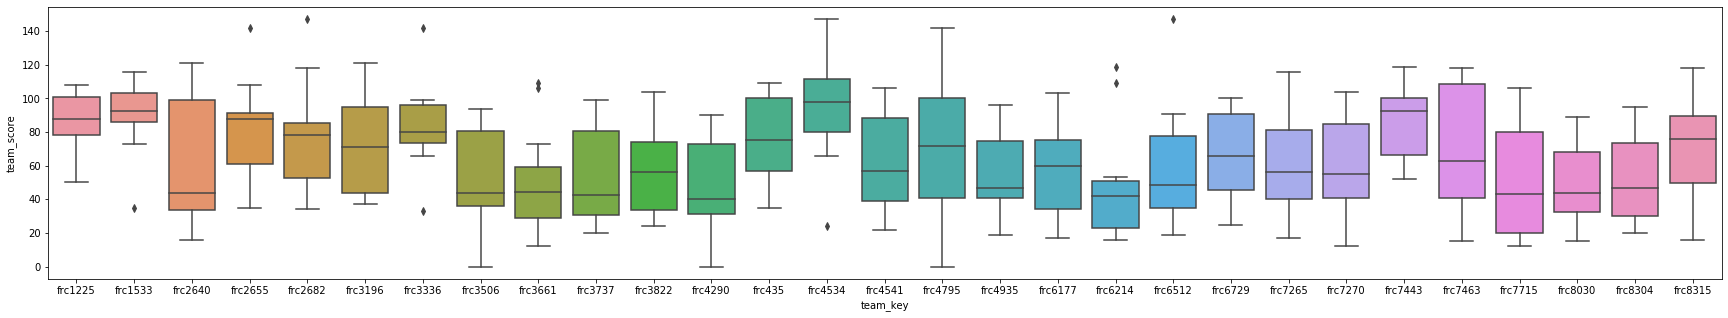

In [6]:
# boxplot team scores
plt.figure(figsize=(30,5))
sns.boxplot(x="team_key", y="team_score", data=team_scores_wak)

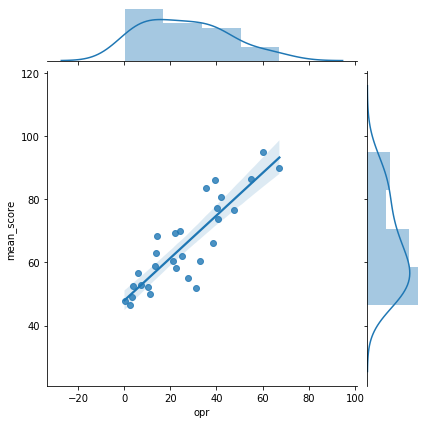

In [7]:
# joint plot opr/team scores
sns.jointplot('opr', 'mean_score', data=team_data_wak, kind='reg')

In [8]:
# regress and get a model that we can use
full_features = ['cells_bottom_auto', 'cells_bottom_teleop', 'cells_inner_auto', 'cells_inner_teleop', 'cells_outer_auto', 'cells_outer_teleop', 'mean_endgame']
full_feature_regression, r2 = perform_regression(team_component_opr_normalized, full_features, 'mean_score')

print(f"R^2: {r2}")

reg_coef = {f: full_feature_regression.coef_[i] for i, f in enumerate(full_features)}
reg_coef = {k: v for k, v in sorted(reg_coef.items(), key=lambda i: i[1])}
reg_coef

R^2: 0.7378634989454189


{'cells_inner_teleop': 0.949979288017503,
 'mean_endgame': 1.0347886229720686,
 'cells_outer_teleop': 1.215430115093112,
 'cells_outer_auto': 1.2741282317417806,
 'cells_bottom_teleop': 1.2929392087170595,
 'cells_inner_auto': 1.2949900716523042,
 'cells_bottom_auto': 2.2438409368192054}

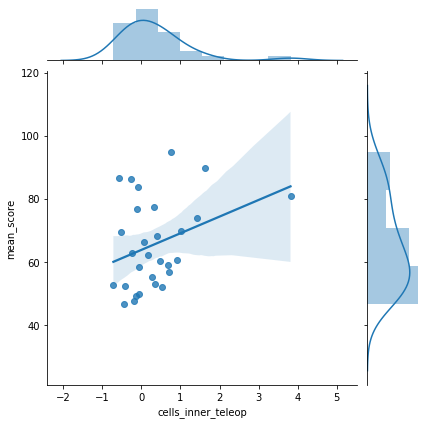

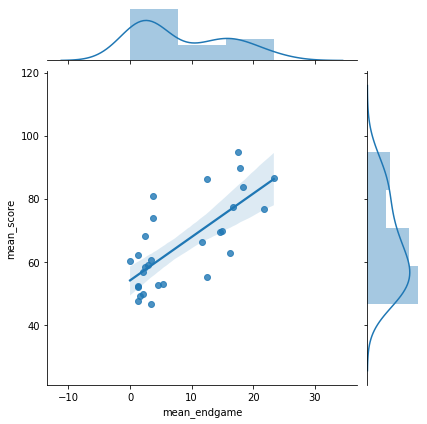

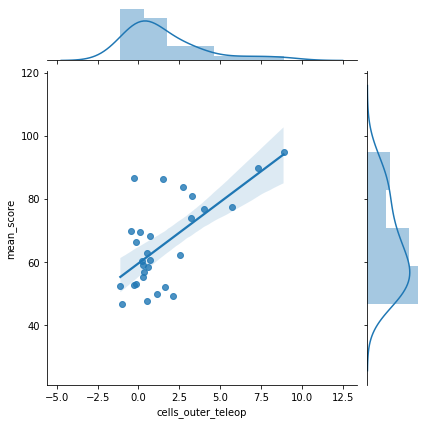

In [9]:
sns.jointplot('cells_inner_teleop', 'mean_score', data=team_component_opr_wak, kind='reg')
sns.jointplot('mean_endgame', 'mean_score', data=team_component_opr_wak, kind='reg')
sns.jointplot('cells_outer_teleop', 'mean_score', data=team_component_opr_wak, kind='reg')

Our team's performance should be modeled pretty accurately with the regression from before, as everything being plotted looks normally distributed (which is good for consistency)

In [17]:
# set up stuff to predict and model alliance scores
def predict_alliance(alliance_keys):
    bot_features = [
        [team_component_opr_normalized.loc[team_component_opr_normalized['team_key'] == team_key].iloc[0][i] for i in full_features] for team_key in alliance_keys
    ]

    predictions = full_feature_regression.predict(bot_features)

    alliance_prediction = np.mean(predictions)
    return alliance_prediction

Now that we have a model to get scores from an alliance with given keys, we can go ahead and use some kind of method to find optimal alliances

In [36]:
teams_available = [
    'frc6565',
    'frc7763',
    'frc8090',
    'frc6240',
    'frc4816',
    'frc7463'
]
alliance = ['frc5160', 'frc5511']

# optimize an alliance given the captain
# O(n^2)
choices = {}
# why code for the general case when there's only two ;)
if len(alliance) == 1:
    for first_pick in teams_available:
        for second_pick in teams_available:
            if first_pick != second_pick and first_pick != captain and second_pick != captain:
                picks = (first_pick, second_pick)
                predicted_score = predict_alliance(alliance + [first_pick, second_pick])
                choices[picks] = predicted_score
elif len(alliance) == 2:
    for first_pick in teams_available:
        if first_pick != captain:
            picks = (first_pick)
            predicted_score = predict_alliance(alliance + [first_pick])
            choices[picks] = predicted_score
choices = {k: v for k, v in sorted(choices.items(), key=lambda x: x[1])}
choices

{'frc6240': 83.94814831116618,
 'frc4816': 85.18800618318154,
 'frc8090': 85.20215521705889,
 'frc7763': 85.43374344640603,
 'frc6565': 85.67149071573999,
 'frc7463': 86.14499723407408}

In [21]:
team_component_opr_wak.loc[team_component_opr_wak['team_key'] == 'frc5160']

,team_key,points_scored,cells_bottom_auto,cells_bottom_teleop,cells_inner_auto,cells_inner_teleop,cells_outer_auto,cells_outer_teleop,mean_endgame,mean_score
9,frc5160,42.045429,2.166404,9.298249,-0.15761,-0.010312,0.061696,0.340771,23.333333,85.0
